# Final Project: 
## Bug Bounty Reward Recommendation Engine

**by Eduard Kotysh**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.




In [217]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Confusion matrix, classification report
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn import metrics
from sklearn.metrics import classification_report

# Decision trees and Random Forest
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Decision tree diagrams.
from IPython.core.display import Image, display
import pydot

# Pipelining vectorized column into other data
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

# Feature extraction from text
from sklearn.feature_extraction.text import *

# Stop words and stemming
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Pretty print
from pprint import pprint



Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [274]:
dataset_file = 'https://raw.githubusercontent.com/ekotysh/bbrec_engine/main/dataset/final_bb_dataset_with_ranges.csv'


header_names = ['Company Name', 'Company Size', 'Open Source', 'Company Revenue',
              'Bounty Awarded', 'Severity Rating', 'Severity Score', 'Weakness',
              'Report Title', 'Report Description', 'URL', 
              'Company State', 'Company Country', 'Company City',
              'Report Year', 'Report Month', 'Report Day', 'Report Hour', 'Report Minute',
              'Bounty Ranges']

# Read the csv in from my github repo
df = pd.read_csv(dataset_file, names=header_names)

# Remove the dollar sign from bounties
# df["Bounty Awarded"] = df["Bounty Awarded"].replace({'\$':''}, regex = True)

# Get the target labels (our bug bounty prices)
labels = df.loc[:,"Bounty Ranges"]


In [275]:
def remove_stop_words(s):
  # combine english, russian and custom non-words
  non_words = {'hi', 'hello', 'pleas', 'like', 'bug', 'bounty', 'bounti', 'nov', 'oct', 
               'ago', 'think', 'thank', 'need', 'howev', 'year hi', 'year hello', 'thank report'}
  stop_words = set(stopwords.words('english')).union(set(stopwords.words('russian'))).union(non_words)
  clean_words = []  # keep track of only clean words (non-stop)
  tokenized_str = word_tokenize(s)
  # go through each token and add it to clean if it's not a stop word
  for word in tokenized_str:
    if word not in stop_words:
      clean_words.append(word)

  # convert from list back to string
  clean_str = ' '.join(clean_words)
  return clean_str 

def remove_numbers(s):
  # go through any sequence of numbers and replace them with nnn using regex
  pattern = '[0-9]+'
  repl = 'nnn'
  return re.sub(pattern, repl, s)

def remove_apostophes(s):
  # replace the occurences of two different types of apostrophes (' & ’) with an empty space
  pattern1 = "(?<=[a-z])'(?=[a-z])"
  repl = ' '
  pattern2 = "(?<=[a-z])’(?=[a-z])"
  s1 = re.sub(pattern1, repl, s)
  return re.sub(pattern2, repl, s1)

def add_stems(s):
  # for each word, return a stem instead
  ps = PorterStemmer()
  stems = ""
  tokenized_str = word_tokenize(s)  # tokenize the string
  for word in tokenized_str:
    stems = stems + " " + ps.stem(word)

  # only return stems
  return stems

# preprocessor for vectorizing text fields
def text_preprocessor(s):
  s = remove_numbers(s)
  s = remove_apostophes(s) 
  s = remove_stop_words(s)
  s = add_stems(s) 
  s = s.lower()
  return s

In [279]:
def vectorize_column(name, column, min_df_val):
  # tokenize by word + remove words that appear in fewer than min_df_val documents.
  #cv = CountVectorizer(min_df=min_df_val, preprocessor=text_preprocessor)
  cv = TfidfVectorizer(min_df=min_df_val, ngram_range=(1, 1),
                       preprocessor=text_preprocessor)

  vectorized = cv.fit_transform(column)
  feature_names = cv.get_feature_names_out()

  print(f"{name} vocabulary: {feature_names}")
  print("Size of vocabulary:", feature_names.shape[0])
  print("Fraction of Non-zero entries:", vectorized.nnz / 
        (vectorized.shape[0]*vectorized.shape[1]))
  print("")
  return cv


def run_decision_tree(ct1, train_X, test_X, train_Y, test_Y):
  # Note: DecisionTreeClassifier gives signific. worse result
  pipeline = make_pipeline(ct1, RandomForestClassifier())

  pipeline.fit(train_X, train_Y)
  score = pipeline.score(test_X, test_Y)

  #classifier = DecisionTreeClassifier(random_state=17)
  #classifier.fit(train_X, train_Y)

  #pred_y = classifier.predict(test_X)

  #results = confusion_matrix(test_Y, pred_y)
  #error = zero_one_loss(test_Y, pred_y)

  #print("Accuracy:", 1-error) # 0.30253353204172884
  print("Score:", score) # with Title: 0.27, with Desc at 2: 0.6915052160953801


def main():
  # Note: 'Company Revenue' actually hurts accuracy
  #'Weakness', 'Report Title', 'Report Description',
  train_columns = ['Company Size', 'Open Source', 
                'Severity Rating', 'Severity Score', 'Weakness', 
                'Report Description', 
                'Company State', 'Company Country', 'Company City',
                'Report Year', 'Report Month', 'Report Day']

  binarize_columns = ['Company Size', 'Open Source',  
                      'Severity Rating', 'Severity Score', 'Weakness', 
                      'Company State', 'Company Country', 'Company City',
                      'Report Year', 'Report Month', 'Report Day']

  # Pick the columns we're gonna train/test with
  clean_df = df[train_columns]
  
  # convert categorical columns into binary features
  binarized_df = pd.get_dummies(clean_df, columns=binarize_columns, drop_first=True)

  # Split our dataset in half - 50% train / 50% test
  mid_point = int(binarized_df.shape[0] / 2) + 1

  # Get our train and test datasets with respective labels
  train_df = binarized_df[1:mid_point]
  test_df  = binarized_df[mid_point:binarized_df.shape[0]]

  train_labels = labels[1:mid_point]
  test_labels = labels[mid_point:labels.shape[0]]
  
  # Show all training columns
  # pprint(train_df.columns.tolist())

  # Vectorize textual fields
  # tokenize by word + remove words that appear in fewer than 20 documents.
  #cv_titl = vectorize_column("Title",       clean_df['Report Title'], 5)
  #ct_titl = make_column_transformer((cv_titl, 'Report Title'), remainder='passthrough')
  cv_desc = vectorize_column("Description", clean_df['Report Description'], 2)
  ct_desc = make_column_transformer((cv_desc, 'Report Description'), remainder='passthrough')
  
  # Run a Decision Tree classifier
  run_decision_tree(ct_desc, train_df, test_df, train_labels, test_labels)


# download stopwords and punkt for nltk
nltk.download('stopwords')
nltk.download('punkt')
print()

main()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Description vocabulary: ['______________nnn' '__cfduid' '__interceptor_malloc' ... 'ценим' 'что'
 'это']
Size of vocabulary: 6274
Fraction of Non-zero entries: 0.014353935244580394

Score: 0.5916542473919523


 ----------

-------------------

-------------------

Newsgroup stuff:

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [ ]:
print(test_data[1])

Hello out there,
If your familiar with the COMET program then this concerns you.
COMET is scheduled to be launched from Wallops Island sometime in June.
Does anyone know if an official launch date has been set?


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [ ]:
def get_train_target_name(label_idx):
  return newsgroups_train.target_names[label_idx]

def get_dev_target_name(label_idx):
  return newsgroups_test.target_names[label_idx]


def Q1(num_examples=5):

  # create a table of Messages and Labels
  data = []

  # go through the first N examples and add the message for that index along with its label name
  # (obtain the label name by looking into target_names by index from train_labels)
  for i in range(num_examples):
    data.append([train_data[i], get_train_target_name(train_labels[i])])

  # print the table using tabulate, along with header
  print(tabulate(data, headers=["Messages:", "Labels:"]))

Q1(5)

Messages:                                                                      Labels:
-----------------------------------------------------------------------------  ------------------
Hi,                                                                            comp.graphics

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file.
I'd like to be able to read the texture rule information, does anyone have
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Seems to be, barring evidence to the contrary, that Koresh was simply          talk.religion.misc
another deranged fana

In [ ]:
# Testing out functions on a small corpus
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
]

# by default uses the 'word' analyzer
cv = CountVectorizer()
matrix = cv.fit_transform(corpus)
feature_names = cv.get_feature_names_out()
print("Tokenized vocabulary: ", feature_names)
print("Size of vocabulary:", feature_names.shape[0])

# Print vectorized form of the sentences
print("Matrix: \n", matrix.toarray())

# For each data point, how many positions are non-zero
print("Non-zero Features Per Data Point:", matrix.nnz / len(corpus))

# Out of all entries in the matrix, what fraction do non-zero entries represent
print("Fraction of Non-zero entries:", matrix.nnz / (matrix.shape[0]*matrix.shape[1]))

print("First feature string:", feature_names[0])
print("Last feature string:", feature_names[feature_names.shape[0]-1])



Tokenized vocabulary:  ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
Size of vocabulary: 9
Matrix: 
 [[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
Non-zero Features Per Data Point: 5.25
Fraction of Non-zero entries: 0.5833333333333334
First feature string: and
Last feature string: this


### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [ ]:
def tokenize(dataset):
  # use Count Vectorizer to tokenize the dataset by 'word' into vocab
  cv = CountVectorizer()
  matrix = cv.fit_transform(dataset)
  vocabulary = cv.get_feature_names_out()
  return matrix, vocabulary

def Q2():
  print("Part 1.")
  # tokenize by 'word' (default)
  matrix, vocab = tokenize(train_data)
  print("Tokenized vocabulary: ", vocab)
  print("Size of vocabulary:", vocab.shape[0])

  # For each data point, how many positions are non-zero on average
  print("Avg Non-zero Features Per Data Point:", matrix.nnz / len(train_data))

  # Out of all entries in the matrix, what fraction do non-zero entries represent
  print("Fraction of Non-zero entries:", matrix.nnz / (matrix.shape[0]*matrix.shape[1]))
  print("First feature string:", vocab[0])
  print("Last feature string:", vocab[vocab.shape[0]-1])
  print("")

  print("Part 2.")
  # restrict the vocabulary
  cv = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
  matrix = cv.fit_transform(train_data)
  vocab = cv.get_feature_names_out()
  print("Tokenized vocabulary: ", vocab)
  print("Size of vocabulary:", vocab.shape[0])
  print("Avg Non-zero Features Per Data Point:", matrix.nnz / len(train_data))
  print("")

  print("Part 3.")
  # tokenize by character bigrams and trigrams
  cv = CountVectorizer(analyzer='char', ngram_range=(2,3))
  matrix = cv.fit_transform(train_data)
  vocab = cv.get_feature_names_out()
  print("Tokenized vocabulary: ", vocab)
  print("Size of vocabulary:", vocab.shape[0])
  print("")
  
  print("Part 4.")
  # tokenize by word + remove words that appear in fewer than 10 documents.
  cv = CountVectorizer(min_df=10)
  matrix = cv.fit_transform(train_data)
  vocab = cv.get_feature_names_out()
  print("Tokenized vocabulary: ", vocab)
  print("Size of vocabulary:", vocab.shape[0])
  print("")

  print("Part 5.")
  # What is the fraction of words in the development vocabulary that is missing from the training vocabulary
  matrix_train, vocab_train = tokenize(train_data)
  matrix_dev, vocab_dev = tokenize(dev_data)
  print("Size of train vocabulary:", vocab_train.shape[0])
  print("Size of dev vocabulary:", vocab_dev.shape[0])

  # how many dev words are missing from train
  missing_count = 0
  # go through each dev word and check if it's in train vocab
  for word in vocab_dev:
    if word not in vocab_train:
      missing_count +=1

  print("Number of words in dev vocab missing from train vocab:", missing_count)
  print("Fraction: ", missing_count/vocab_dev.shape[0])
Q2()

Part 1.
Tokenized vocabulary:  ['00' '000' '0000' ... 'zware' 'zwarte' 'zyxel']
Size of vocabulary: 26879
Avg Non-zero Features Per Data Point: 96.70599803343165
Fraction of Non-zero entries: 0.0035978272269590263
First feature string: 00
Last feature string: zyxel

Part 2.
Tokenized vocabulary:  ['atheism' 'graphics' 'space' 'religion']
Size of vocabulary: 4
Avg Non-zero Features Per Data Point: 0.26843657817109146

Part 3.
Tokenized vocabulary:  ['\x08i' '\x08ib' '\t"' ... 'þ ' 'þ d' 'þ h']
Size of vocabulary: 35478

Part 4.
Tokenized vocabulary:  ['00' '000' '01' ... 'yourself' 'zero' 'zip']
Size of vocabulary: 3064

Part 5.
Size of train vocabulary: 26879
Size of dev vocabulary: 16246
Number of words in dev vocab missing from train vocab: 4027
Fraction:  0.24787640034470024


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [ ]:
def do_k_neighbors(k_val, train_dataset, eval_dataset):
  model = KNeighborsClassifier(n_neighbors=k_val)
  model.fit(train_dataset, train_labels)            # train
  predicted_labels = model.predict(eval_dataset)    # eval
  # score using f1 weighted strategy
  f1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
  print("{:<20} {:<50}".format(f"k={k_val}",f"f1 score={f1}"))
  return f1

def do_multinomial(a_val, train_dataset, eval_dataset):
  multinomial_model = MultinomialNB(alpha=a_val)
  multinomial_model.fit(train_dataset, train_labels)          # train
  predicted_labels = multinomial_model.predict(eval_dataset)  # evaluate 
  # score using f1 weighted strategy
  f1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
  print("{:<20} {:<50}".format(f"alpha={a_val}",f"f1 score={f1}"))

def do_logistic(c_val, train_dataset, eval_dataset):
  lr_model = LogisticRegression(C=c_val, solver="liblinear", multi_class="auto")
  lr_model.fit(train_dataset, train_labels)          # train
  predicted_labels = lr_model.predict(eval_dataset)  # evaluate 
  # score using f1 weighted strategy
  f1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
  # apply square func to model's coef weights, convert result to list and sum them up
  sum_squares = list(map(sum,list(map(lambda x:x**2, lr_model.coef_))))
  print("{:<20} {:<40} {:<40}".format(f"C={c_val}",f"f1 score={f1}", f"sum_squares={sum_squares}"))

  # I was doing the calculation of the sum of squares manually in a for loop
  # but Jorge helped me out with the one-liner above, so commenting this out
  # for row in range(lr_model.coef_.shape[0]-1):
  #  row_sum = np.sum(lr_model.coef_ ** 2, axis=0)
  #  sum_squared_weights.append(row_sum)
  

def find_optimal_alpha(train_dataset):
  multinomial_model = MultinomialNB()
  multinomial_model.fit(train_dataset, train_labels) 

  # Run a GridSearch fitting over our Multinomial model with different values 
  # of alpha param in range: 0.01 - 1. Use 5 splits and score by accuracy
  var_alpha = {'alpha': np.logspace(0.01,1, num=100)}
  grid_search = GridSearchCV(multinomial_model, var_alpha, cv=5, verbose=1, scoring='accuracy') 
  grid_search.fit(train_dataset, train_labels)

  print(f"Best alpha: {grid_search.best_params_}")

def find_optimal_C(train_dataset):
  lr_model = LogisticRegression(solver="liblinear", multi_class="auto", max_iter=10000)
  lr_model.fit(train_dataset, train_labels)

  # Run a GridSearch fitting over our LogisticRegression model with different values 
  # of C param in range: 0.01 - 10. Use 2 splits and score by accuracy (otherwise took too long)
  var_c = {'C': np.logspace(0.01,10, num=10)}
  grid_search = GridSearchCV(lr_model, var_c, cv=2, verbose=1, scoring='accuracy') 
  grid_search.fit(train_dataset, train_labels)

  print(f"Best C: {grid_search.best_params_}")


def Q3():
  cv = CountVectorizer()
  matrix_train = cv.fit_transform(train_data)
  matrix_dev = cv.transform(dev_data)

  print("train matrix:", matrix_train.shape)
  print("dev matrix:", matrix_dev.shape)
  print()

  print("K-Neighbors models:")
  best_f1 = 0
  best_k = 1
  # run different k-neighbors models with k between 1-10
  for k in range(1,10):
    f1 = do_k_neighbors(k, matrix_train, matrix_dev)
    # save off the best f1 and corresponding k
    if f1 > best_f1:
      best_f1 = f1
      best_k = k
  
  print(f"Best k={best_k}, f1={best_f1}")

  print()
  print("Multinomial models:")
  alphas = [0.001, 0.01, 0.1, 1, 1.023, 1.5, 3, 10]
  for a in alphas:
    do_multinomial(a, matrix_train, matrix_dev)

  print("Finding optimal alpha...")
  find_optimal_alpha(matrix_train)

  print()
  print("Logistic Regression models:")
  c_vals = [0.001, 0.01, 0.1, 1, 1.023, 10, 100]
  for c in c_vals:
    do_logistic(c, matrix_train, matrix_dev)

  print("Finding optimal C value...")
  find_optimal_C(matrix_train)
  print()

Q3()

# References:
# Jorge helped me out with a one-liner function for calculating the sum of squares

train matrix: (2034, 26879)
dev matrix: (676, 26879)

K-Neighbors models:
k=1                  f1 score=0.3805030018531525                       
k=2                  f1 score=0.38054212404441684                      
k=3                  f1 score=0.4084150225437623                       
k=4                  f1 score=0.4031227993847515                       
k=5                  f1 score=0.4287607236218357                       
k=6                  f1 score=0.4466650540867595                       
k=7                  f1 score=0.45047910006117586                      
k=8                  f1 score=0.44698358117081094                      
k=9                  f1 score=0.4365666176198027                       
Best k=7, f1=0.45047910006117586

Multinomial models:
alpha=0.001          f1 score=0.7702518836155706                       
alpha=0.01           f1 score=0.7751663218544357                       
alpha=0.1            f1 score=0.7903052385098862                       
alpha=1 

### ANSWER: 

**Part 5:**

Because KNN works by finding relationship with nearest neighbors, it is not well-suited for independent categorical data. Additionally, the idea of nearest neighbors in our case doesn't really make for a meaningful relationship. The values in our sparse matrix represent presence of a specific vocabulary word for that data point, and these presence are not necessarily related to each other by distance (meaning, the fact that there is a vocabulary word present at data point 1 doesn't create a meaningful relationship with a different vocab word presence at data point 2).


**Part 6:**

Naive Bayes is truly independent and thus particularly well-suited for categorical data with a large number of independent features, which is what we have here. In this case also repetitive features will have extra correlation, which is what we want. 

Logistic Regression, while also well-suited for categorical data, attempts to find an optimal decision boundary between categories based on correlations between features and thus tends to introduce bias of assigning 1 for positive classes and 0 for negative classes. It is thus not able to handle a large number of independent categorical features, as it will be very prone to overfitting. In our case, making a decision based on correlation bias is not necessarily accurate, since our features are independent and many, and repetitive features will not produce extra correlation like they do in Naive Bayes.

**Part 7:**

As the C value increases, so does the sum of squared weights. So the regularization strength is inversely proportional to C value. The larger the C value, the less regularization is happening.


### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [ ]:
def get_top_20(coefs, feature_names):
  print("Top 20 Features:")
  top_20_features = []
  top_20_indecies = []
  # get top 5 features and indecies for each of the 4 topics, so will be 20 total
  # for each topic, get the coef weights and extract their features
  for i in range(coefs.shape[0]):
    # get the sorted indecies for these coeffs
    sorted_indecies = np.argsort(coefs[i])[::-1]

    # get the index of the top-5 features for this topic
    top_5_topic_indecies = sorted_indecies[:5]

    # get the names of the top 5 features per topic and combine them all
    for item in np.flip(feature_names[top_5_topic_indecies]):
      top_20_features.append(item)

    # get the indecies of the top 5 features per topic and combine them all
    for index in np.flip(top_5_topic_indecies):
      top_20_indecies.append(index)

  print(top_20_features)
  print("")
  return top_20_features, top_20_indecies


def Q4():
  # tokenize by word bigrams
  cv = CountVectorizer(analyzer='word', ngram_range=(2,2))
  matrix = cv.fit_transform(train_data)
  vocab = cv.get_feature_names_out()
  print("Vocabulary: ", vocab)
  print("Size of vocabulary:", vocab.shape[0])
  print("")

  # train Logistic Regression model
  lr_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
  lr_model.fit(matrix, train_labels)

  # get top 5 features for each topic
  top_20, indecies = get_top_20(lr_model.coef_, vocab)

  # get all the unique indecies for headers
  header_indecies = np.unique(train_labels) 
  headers = []
  # translate them into topic names
  for idx in header_indecies:
    headers.append(get_train_target_name(train_labels[idx]))

  # prepend an empty header column (for the features column)
  headers_sorted = list(" ") + sorted(headers)

  # go through top 20 and construct each column of weights for each topic
  table_data = []
  for i in range(len(top_20)):
    # index into coef by topic, then by the appropriate index of that top20 bigram
    column1 = lr_model.coef_[0][indecies[i]]
    column2 = lr_model.coef_[1][indecies[i]]
    column3 = lr_model.coef_[2][indecies[i]]
    column4 = lr_model.coef_[3][indecies[i]]
    
    # add the data into the table
    table_data.append([top_20[i], column1, column2, column3, column4])

  print(tabulate(table_data, headers_sorted))

np.set_printoptions(threshold=1000)
Q4()

Vocabulary:  ['00 10' '00 12' '00 13' ... 'zwarte gaten' 'zyxel 14' 'zyxel v32bis']
Size of vocabulary: 194891

Top 20 Features:
['are you', 'you are', 'was just', 'cheers kent', 'claim that', 'is there', 'out there', 'comp graphics', 'in advance', 'looking for', 'it was', 'and such', 'sci space', 'the moon', 'the space', 'of jesus', 'but he', 'ignorance is', 'cheers kent', 'the fbi']

                 alt.atheism    comp.graphics    sci.space    talk.religion.misc
-------------  -------------  ---------------  -----------  --------------------
are you            0.446953         -0.248257   -0.0971355            -0.305625
you are            0.47274          -0.279894   -0.481305              0.0283729
was just           0.48205          -0.131418   -0.128882             -0.227469
cheers kent        0.55572          -0.697918   -0.663766              0.534808
claim that         0.605549         -0.199067   -0.274345             -0.140364
is there          -0.340882          0.754998   

## ANSWER: 
Some surprising features I found:


*   We see a duplicate: `cheers kent` that shows up with a decently positive weight in 2 different topics: `alt.atheism` and `talk.religion.misc`. This is not great, because it may have difficulty deciding between those two topics when this term shows up in a message. Also, who the heck is Kent?

*   We see what initially looks like a duplicate, but it's not: `are you` and `you are` since they represent different contextual meaning in a sentence, they are both relevant.

*   We see the name of the topic in the vocabulary: `comp graphics`, which produces a very strong signal to the model that the message belongs to `comp graphics` topic (0.8). I suppose it is mentioned enough in the messages that the model decided it's a good frequent term to base the confidence off. It may trigger a false positive when used in the negative context in a message, ie: `not comp graphics`.

*   Some of these word bigrams I feel like are not really representative of the topic and are more like stop words, for example: `it was`, `but he`, `you are`. I would prune them out, since they don't carry a strong weight and not representative of the context of the message.

*   The bigram: `looking for` has a very strong weight of `1.10` in the comp.graphics topic. I guess there were a lot of messages where people were searching for something (maybe some visual features) related to computer graphics. Seems overexaggerated.

*   Finally, how did `the fbi` show up as a signal in the `religion.misc`? :)

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def remove_stop_words(s):
  # get the english stop words
  stop_words = set(stopwords.words('english'))
  clean_words = []  # keep track of only clean words (non-stop)
  tokenized_str = word_tokenize(s)
  # go through each token and add it to clean if it's not a stop word
  for word in tokenized_str:
    if word not in stop_words:
      clean_words.append(word)

  # convert from list back to string
  clean_str = ' '.join(clean_words)
  return clean_str 

def remove_numbers(s):
  # go through any sequence of numbers and replace them with nnn using regex
  pattern = '[0-9]+'
  repl = 'nnn'
  return re.sub(pattern, repl, s)

def remove_apostophes(s):
  # replace the occurences of two different types of apostrophes (' & ’) with an empty space
  pattern1 = "(?<=[a-z])'(?=[a-z])"
  repl = ' '
  pattern2 = "(?<=[a-z])’(?=[a-z])"
  s1 = re.sub(pattern1, repl, s)
  return re.sub(pattern2, repl, s1)

def add_stems(s):
  # for each word, return a stem instead
  ps = PorterStemmer()
  stems = ""
  tokenized_str = word_tokenize(s)  # tokenize the string
  for word in tokenized_str:
    stems = stems + " " + ps.stem(word)

  # only return stems
  return stems

# my custom preprocessor
def better_preprocessor(s):
  s = remove_numbers(s)
  s = remove_stop_words(s)
  s = remove_apostophes(s) 
  s = add_stems(s) 
  s = s.lower()
  return s
  

def run_lr_with(title, c_val, train_dataset, eval_dataset):
  lr_model = LogisticRegression(C=c_val, solver="liblinear", multi_class="auto")
  lr_model.fit(train_dataset, train_labels)             # train
  predicted_labels = lr_model.predict(eval_dataset)     # evaluate 
  # score using f1 weighted strategy
  f1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
  print(f"f1 score ({title}): {f1}")

def Q5():
  cv_no_preprocess = CountVectorizer()
  matrix_train = cv_no_preprocess.fit_transform(train_data)
  matrix_dev = cv_no_preprocess.transform(dev_data)
  vocab = cv_no_preprocess.get_feature_names_out()
  original_vocab_size = vocab.shape[0]
  print("Original Vocab size:", original_vocab_size)

  run_lr_with("default preprocessing", 0.5, matrix_train, matrix_dev)

  print("Vectorizing with custom preprocessor...")
  # inject the custom pre-processor into CountVectorizer
  cv_with_preprocess = CountVectorizer(preprocessor=better_preprocessor)
  matrix_train = cv_with_preprocess.fit_transform(train_data)
  matrix_dev = cv_with_preprocess.transform(dev_data)
  vocab = cv_with_preprocess.get_feature_names_out()
  print("New Vocab size:", vocab.shape[0])
  print("Vocab difference:", original_vocab_size - vocab.shape[0])

  run_lr_with("my preprocessing", 0.5, matrix_train, matrix_dev)
    
# download stopwords and punkt for nltk
nltk.download('stopwords')
nltk.download('punkt')
Q5()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original Vocab size: 26879
f1 score (default preprocessing): 0.7084739776490449
Vectorizing with custom preprocessor...
New Vocab size: 18175
Vocab difference: 8704
f1 score (my preprocessing): 0.7300555306449114


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

Training with C=0.001...
Non Zero features: 6
New vocab size:  3
{'the': 0, 'that': 1, 'to': 2}
f1 score: 0.33442786629546206

Training with C=0.01...
Non Zero features: 35
New vocab size:  17
{'and': 0, 'for': 1, 'is': 2, 'not': 3, 'on': 4, 'space': 5, 'that': 6, 'the': 7, 'graphics': 8, 'image': 9, 'jpeg': 10, 'of': 11, 'they': 12, 'to': 13, 'you': 14, 'he': 15, 'it': 16}
f1 score: 0.4625536287338924

Training with C=0.03...
Non Zero features: 124
New vocab size:  67
{'an': 0, 'and': 1, 'atheism': 2, 'but': 3, 'don': 4, 'for': 5, 'from': 6, 'god': 7, 'graphics': 8, 'image': 9, 'is': 10, 'islam': 11, 'it': 12, 'matthew': 13, 'my': 14, 'not': 15, 'of': 16, 'on': 17, 'one': 18, 'people': 19, 'ra': 20, 'religion': 21, 'so': 22, 'space': 23, 'that': 24, 'the': 25, 'they': 26, 'we': 27, 'what': 28, 'with': 29, 'any': 30, 'anyone': 31, 'as': 32, 'can': 33, 'color': 34, 'computer': 35, 'file': 36, 'files': 37, 'he': 38, 'in': 39, 'points': 40, 'thanks': 41, 'use': 42, 'using': 43, 'was': 44,

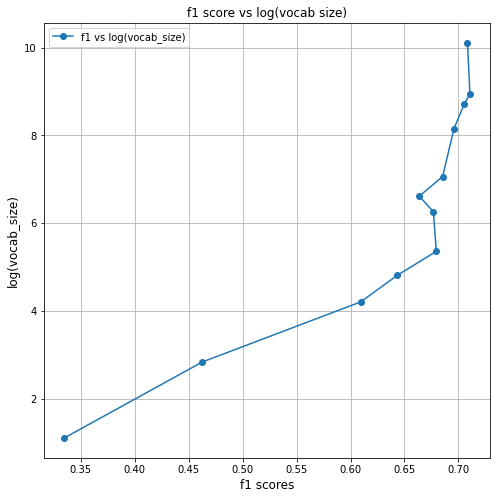

In [ ]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    # keep track of f1 scores and vocab sizes
    f1_scores = []
    vocab_sizes = []

    c_values = [0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 10, 50, 100, 1000]
    vectorizer = CountVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vocab = vectorizer.get_feature_names_out()

    for c in c_values:
      print(f"Training with C={c}...")
      # 1. train LR model with L1 regularization - we'll call this LR1
      lr1_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
      lr1_model.fit(vtrain, train_labels) # train

      # 2. enumerate through LR1 model and find .coef_ != 0 - these are the features that are used
      v_new = {}
      v_new_idx = 0
      print("Non Zero features:", np.count_nonzero(lr1_model.coef_))
      # go through each topic
      for topic in range(lr1_model.coef_.shape[0]):
        weights = lr1_model.coef_[topic]  # grab the weights
        # enumerate through the weights and for non-zero ones, add the corresponding features to the new vocabulary
        for i,j in enumerate(weights):
          if (j != 0):
            #print("{:<30} {:<20} {:<20}".format(f"Topic: {get_target_name(train_labels[topic])}", f"Feature: {vocab[i]}", f"Score: {j}"))
            if (vocab[i] not in v_new):
              v_new[vocab[i]]=v_new_idx
              v_new_idx += 1
 

      # 3. create a new vocabulary V_NEW containing only features that are non-zero (Save the size of this vocabulary)
      v_new_size = len(v_new)
      print("New vocab size: ", v_new_size)
      vocab_sizes.append(v_new_size)  # track the new vocab size
      print(v_new)

      # 4. create a new vectorized dataset with vectorizer_new = CountVectorizer(vocabulary=V_NEW) and vectorizer_new.transform(train_data)
      vectorizer_new = CountVectorizer(vocabulary=v_new)
      vtrain_new = vectorizer_new.transform(train_data)
      vdev_new = vectorizer_new.transform(dev_data)

      # 5. train LR model with L2 regularization - we'll call this LR2
      lr2_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2")
      lr2_model.fit(vtrain_new, train_labels)         # train
      predicted_labels = lr2_model.predict(vdev_new)  # evaluate

      # 6. calculate f1 score of LR2
      f1 = metrics.f1_score(dev_labels, predicted_labels, average="weighted")
      f1_scores.append(f1)
      print(f"f1 score: {f1}")
      print("")

    # 7. Plot f1 score vs log(vocabulary size)
    fig, axis = plt.subplots(figsize=(8,8))
    plt.title("f1 score vs log(vocab size)")

    # plot f1_scores for X axis and log(vocab_size) for Y.
    axis.plot(f1_scores, np.log(vocab_sizes), marker="o", label="f1 vs log(vocab_size)")

    # label the axis
    axis.set_xlabel('f1 scores', fontsize=12)
    axis.set_ylabel('log(vocab_size)', fontsize=12)

    plt.grid(True)     # show the grid
    plt.legend()       # show the legend
    plt.show()

Q6()

## ANSWER: 

As we increase C value for L1 regularization, the vocabulary gets large, because increasing C value means less regularization is happening.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [ ]:
def Q7():
  # setup the Tfidf Vectorizer and transform train/dev sets
  vectorizer = TfidfVectorizer()
  vtrain = vectorizer.fit_transform(train_data)
  vdev = vectorizer.transform(dev_data)
  vocab = vectorizer.get_feature_names_out()

  # setup the Logistic Regression and train & evaluate
  lr2_model = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
  lr2_model.fit(vtrain, train_labels)      # train
  predictions = lr2_model.predict(vdev)    # evaluate

  # get the f1 score
  f1 = metrics.f1_score(dev_labels, predictions, average="weighted")
  print("f1 score:", f1)
  print("")

  # get the posterior probabilities 
  confidences = lr2_model.predict_proba(vdev)

  r_ratios = []
  errors = {} # map of r-ratios to misclassified samples
  # go through all predictions and examine the posterior probability for each
  for idx in range(len(predictions)):
    prediction = int(predictions[idx])  # get our prediction out
    label = int(dev_labels[idx])        # get the actual label for this data point
    
    # get the set of confidence probabilities for each class, take the one that belongs to our prediction
    confidence_set = confidences[idx]
    confidence = confidence_set[prediction]

    # we want to look at the problems, when prediction was wrong (that's when R ratio will be the highest)
    if prediction != label:
      # calculate R ratio
      # print(f"prediction: {prediction}, confidence: {confidence}, confidence set: {confidence_set}, actual label: {label}")
      misclassification = f"Misclassified {get_dev_target_name(label)} as {get_dev_target_name(prediction)}"
      # print(misclassification)
      r_ratio = confidence / confidence_set[label]
      r_ratios.append(r_ratio)  # save r-ratio into a list
      errors[r_ratio] = misclassification + "\nDocument:\n" + dev_data[idx]  # save the misclassified label & data point

  # take the top 3 r_ratios
  r_ratios.sort(reverse=True)
  top3_r = r_ratios[:3]
  print("=== Top 3 Errors: ===\n")
  for r in top3_r:
    print(f"r_ratio = {r}\n{errors[r]}\n\n------------------------------------\n")
Q7()

f1 score: 0.7597662427853104

=== Top 3 Errors: ===

r_ratio = 929.3571373334202
Misclassified talk.religion.misc as comp.graphics
Document:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making cop

## ANSWER: 

**1. Explain what the R ratio describes:**

  R ratio gives a measure of how wrong the model is at different data points. 
In cases when the model is right, the R ratio = 1. In cases when the model is wrong, the R ratio = winning confidence level / confidence level of the actually correct class. The more confident the model was of the *wrong* answer, the higher the R ratio would be. Thus, it shows us the biggest errors the model is making and is useful for error correctness.

**2. How is TfidfVectorizer different than CountVectorizer?**

  While they both transform text into numeric form useful for machine learning models, the `CountVectorizer` simply produces the frequency of each token with respect to the index in the vocabulary. However, the `TfidfVectorizer` hints at the overall originality of the token by counting how many times it appears in the document vs the number of documents that token appears in.

**3. Mistakes the model is making:**

*   In general, the model is often misclassifying `talk.religion.misc` as `alt.atheism` and vice versa because they are similar topics
*   The two biggest mistakes happened when the model was highly confident the topic was `comp.graphics` where in reality it was `talk.religion.misc` (r-ratio of 929 and 325). When we look at the actual documents, we can see that there is a frequent mention of computer terms in it, like FTP information, Windows, Macintosh, Latex, word processor etc - the terms that the model likely learned to associate with computer graphics topic. In this case, it *might* help if we remove these specific computer terms, although we need to see how much it will hurt the existing correctly classified messages. We also need to teach the model about more contextual information rather than frequency of words - in fact it highlights, why just using the frequency is not a very accurate solution for text classification. The last misclassified document is quite short and doesn't contain any context towards a specific topic, so it's very difficult to classify. Additionally, the topics are similar, so that was fairly easy to misclassify. One improvement we could add here is to adjust the confidence based on the length of the document, since the shorter documents have a higher chance of being misclassified due to inavailability of useful information. 
Final suggestion is to amplify certain keywords that really trigger the likelyhood of a certain topic like Bible, Mormon, etc. This should increase their weight and produce slighly better result.


versa.

Reading reference: 

https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [ ]:
# changes:
# - remove certain computer terms that are acting as false positives in religion documents
# - amplify certain keywords that really matter to a specific topic (increase their weight by injecting higher frequency)
# - remove stop words


# my custom preprocessor
def custom_preprocessor(s):
  removal_list = ["FTP", "ftp", "Windows", "Microsoft", "Macintosh", "Apple", "ASCII", "word processor"]
  amplified_keywords = ["Mormon", "Bible"]

  final_str = ""
  # remove all words from removal_list
  for word in removal_list:
    final_str = s.replace(word, "")

  # double the frequency of certain keywords in amplified_keywords
  for word in amplified_keywords:
    if word in s:
      final_str = final_str + " " + word  # double it
  
  return final_str

def Q8():
  # setup the Tfidf Vectorizer and transform train/dev sets
  vectorizer = TfidfVectorizer()
  vtrain = vectorizer.fit_transform(train_data)
  vdev = vectorizer.transform(dev_data)
  vocab = vectorizer.get_feature_names_out()

  # setup the Logistic Regression and train & evaluate
  lr2_model = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
  lr2_model.fit(vtrain, train_labels)      # train
  predictions = lr2_model.predict(vdev)    # evaluate

  # get the f1 score
  f1 = metrics.f1_score(dev_labels, predictions, average="weighted")
  print("Base f1 score:", f1)
  print("")


  # use the custom preprocessor to make changes and transform train/dev sets
  vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor, stop_words='english')
  vtrain = vectorizer.fit_transform(train_data)
  vdev = vectorizer.transform(dev_data)
  vocab = vectorizer.get_feature_names_out()

  # setup the Logistic Regression and train & evaluate
  lr2_model = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
  lr2_model.fit(vtrain, train_labels)      # train
  predictions = lr2_model.predict(vdev)    # evaluate

  # get the f1 score
  f1 = metrics.f1_score(dev_labels, predictions, average="weighted")
  print("New f1 score:", f1)
  print("")

Q8()

Base f1 score: 0.7597662427853104

New f1 score: 0.7679107646550714

